# ML Challenge (Optional)

Train, test, optimize, and analyze the performance of a classification model using a methodology of your choice for the randomly generated moons dataset.

You are not being evaluated for the performance of your model. Instead, we are interested in whether you can implement a simple but rigorous ML workflow.

Show all of your work in this notebook.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

pd.options.mode.chained_assignment = None

## Dataset

In [4]:
# DO NOT MODIFY
from sklearn.datasets import make_moons

X, Y = make_moons(random_state=42, n_samples=(50, 450), noise=0.25)

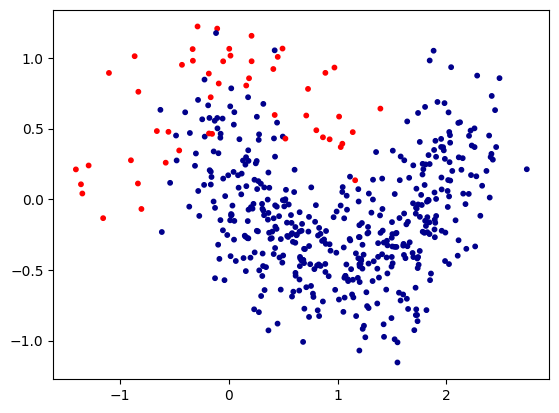

In [5]:
cmap = mpl.colors.ListedColormap(['red', 'darkblue'])
plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap, s=10)

Upon initial observation of the generated moon dataset, we see that there is a large amount of overlap between the two labels. Our goal will be to classify points as belonging to a specific cluster. The difficulty in optimizing will be in correctly labeling the red moon section, since there exist less of the red label and it is interspersed within the blue label's half circle.

Compared to other more complicated datasets, there is not much to observe here due to the simplicity of the dataset.

## Training

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=1)

In [7]:
nn = MLPClassifier(
    activation="relu",
    solver="adam",  # lbfgs, sgd, adam
    max_iter=200,  # number of epochs
    alpha=1e-5, 
    learning_rate="constant",  # constant, invscaling, adaptive
    learning_rate_init = 0.001,
    hidden_layer_sizes=(5,2), 
    early_stopping=False,
    random_state=1)

nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

/mnt/c/UMich/mdst/2023-Tutorials/mdst_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.92


$$\mathrm{accuracy} = \frac{1}{n}\sum_{i=0}^{n-1} \mathbb{1}(\hat{y}_i = y_i)$$
$$\hat y: \mathrm{predicted}\,\mathrm{value}$$
$$y: \mathrm{true}\,\mathrm{value}$$
$$\mathbb{1}: \mathrm{indicator}\,\mathrm{function}$$

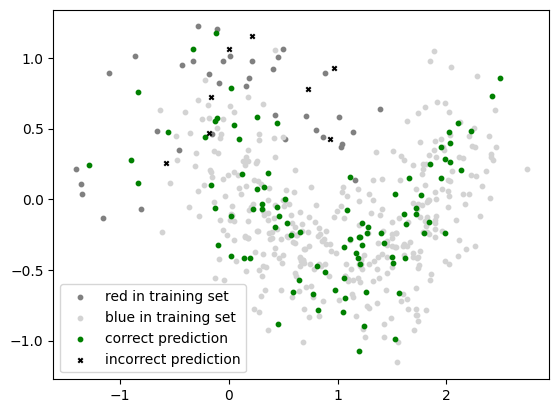

In [9]:
correct = y_test == y_pred
incorrect = y_test != y_pred
plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], c="grey", label="red in training set", s=10)
plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], c="lightgrey", label="blue in training set", s=10)
plt.scatter(X_test[correct,0], X_test[correct,1], label="correct prediction", c='green', s=10)
plt.scatter(X_test[incorrect,0], X_test[incorrect,1], label="incorrect prediction", c='black', marker="x", s=10)
plt.legend()

As we predicted prior to training, most of the errors are around where the red labeled half circle is located. However, for a first naive run of a model, our performance is pretty good, with 91% correct predictions. We're not being graded on accuracy here, so let's see how we can show off our machine learning skills to improve this model.

First, let's examine the loss curve of the network, and look for any signs where the model's training could be suboptimal:

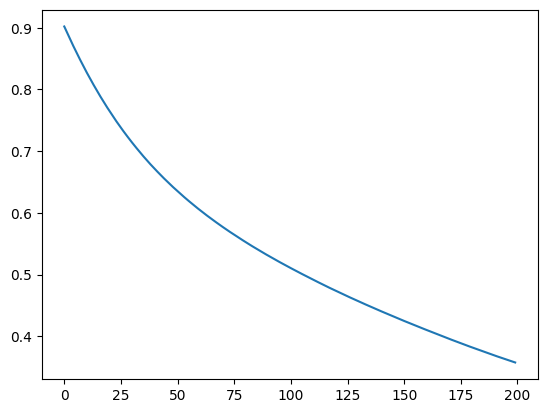

Final loss: 0.3577762192207948


In [10]:
# cross-entropy loss function
plt.plot(nn.loss_curve_)
plt.show()
print("Final loss:", nn.loss_curve_[-1])

It appears that the model was making steady progress prior to getting cut off at the 200th iteration. If we were to add additional iterations, it is likely that we could get even better performance.

In [11]:
# helper function
def train_nn(
        activation="relu", 
        solver="adam",  # lbfgs, sgd, adam
        max_iter=200,
        alpha=1e-5, 
        learning_rate="constant",  # constant, invscaling, adaptive
        learning_rate_init = 0.001,
        hidden_layer_sizes=(5,2)
        ):
    nn = MLPClassifier(
        activation=activation,
        solver=solver,  # lbfgs, sgd, adam
        max_iter=max_iter,  # number of epochs
        alpha=alpha,
        learning_rate=learning_rate,
        learning_rate_init=learning_rate_init,
        hidden_layer_sizes=hidden_layer_sizes,
        early_stopping=False,
        random_state=1)

    nn.fit(X_train, y_train)
    y_pred = nn.predict(X_test)
    return nn, accuracy_score(y_test, y_pred)

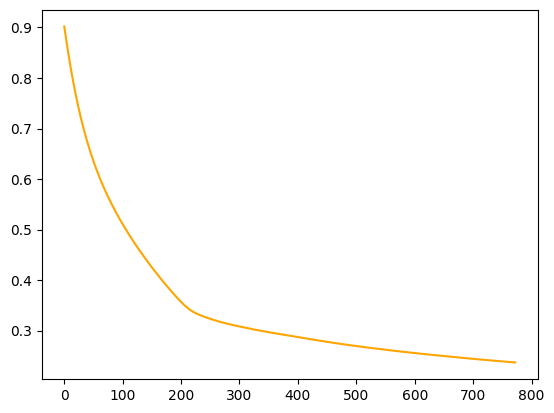

Final loss: 0.23678104852782206


In [12]:
nn, accuracy = train_nn(max_iter=2000)

plt.plot(nn.loss_curve_, 'orange')
plt.show()
print("Final loss:", nn.loss_curve_[-1])

In [13]:
print(nn.n_iter_)

773


It seems that sklearn is stopping the model at 773 iterations (I'm not sure how to get around this, even after setting `early_stopping=False`), which for our purposes is sufficient. Computation time is no more than a few seconds for this simple classification problem, so the number of iterations could be extended up until overfitting occurs. I'm not sure how to get sklearn to plot/output validation scores alongside loss scores (to determine overfitting), but doing so would give more information about the model's training progress.

## Hyperparameter Optimization
Common sources for optimization of neural networks are setting the initial learning rate, and the ideal alpha value. One option would be to train the network at various values of these hyperparameters, and plot the performance of the network to determine ther ideal values. Luckly, scikit learn provides `GridSearchCV`, which effectively does this for us to find the best values among a set of potential values that we select. k-fold cross validation is also included; we will choose to use k=5 since it coincides up with our initial choice of 80/20 for train test split (4/5=80% of data for training, 1/5=20% for testing, across 5 interations of picking a specific fold to be our validation/testing data).

In [15]:
from sklearn.model_selection import GridSearchCV
nn = MLPClassifier(
    activation="relu",
    solver="adam",  # lbfgs, sgd, adam
    max_iter=770,  # number of epochs
    alpha=1e-5, 
    learning_rate="constant",  # constant, invscaling, adaptive
    learning_rate_init = 0.001,
    hidden_layer_sizes=(5,2), 
    early_stopping=False,
    random_state=1)

parameters = {
    "alpha": [0.0005, 0.001, 0.01, 0.05],
    "learning_rate_init": [0.001, 0.005, 0.05],
    "learning_rate": ["constant", "adaptive"]
}
gscv = GridSearchCV(nn, parameters, n_jobs=-1, cv=5)
gscv.fit(X,Y)
print(gscv.best_params_)

/mnt/c/UMich/mdst/2023-Tutorials/mdst_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (770) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/c/UMich/mdst/2023-Tutorials/mdst_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (770) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/c/UMich/mdst/2023-Tutorials/mdst_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (770) reached and the optimization hasn't converged yet.
  warnings.warn(
/mnt/c/UMich/mdst/2023-Tutorials/mdst_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (770) reached and the optimization has

{'alpha': 0.01, 'learning_rate': 'constant', 'learning_rate_init': 0.05}


In [30]:
nn = MLPClassifier(
    activation="relu",
    solver="adam",  # lbfgs, sgd, adam
    max_iter=770,  # number of epochs
    alpha=0.01,
    learning_rate="constant",  # constant, invscaling, adaptive
    learning_rate_init = 0.05,
    hidden_layer_sizes=(5,2), 
    early_stopping=False,
    random_state=1)

parameters = {
    "hidden_layer_sizes": [(5,2), (5,5), (7,7), (5,7), (5,10)]
}
gscv = GridSearchCV(nn, parameters, n_jobs=-1, cv=5)
gscv.fit(X,Y)
print(gscv.best_params_)

{'hidden_layer_sizes': (5, 5)}


In [18]:
gscv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'param_learning_rate', 'param_learning_rate_init', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [24]:
for i, mean_fit_time in enumerate(gscv.cv_results_["mean_fit_time"]):
    for n in range(0,5):
        print(round(gscv.cv_results_[f"split{str(n)}_test_score"][i],2), "", end="")
    print()

0.91 0.91 0.94 0.95 0.94 
0.91 0.95 0.95 0.95 0.95 
0.93 0.97 0.94 0.96 0.96 
0.91 0.91 0.94 0.95 0.94 
0.91 0.95 0.95 0.95 0.95 
0.93 0.97 0.94 0.96 0.96 
0.91 0.91 0.94 0.95 0.94 
0.91 0.95 0.95 0.95 0.95 
0.93 0.97 0.94 0.96 0.96 
0.91 0.91 0.94 0.95 0.94 
0.91 0.95 0.95 0.95 0.95 
0.93 0.97 0.94 0.96 0.96 
0.91 0.91 0.94 0.95 0.94 
0.92 0.95 0.95 0.95 0.95 
0.93 0.97 0.97 0.96 0.96 
0.91 0.91 0.94 0.95 0.94 
0.92 0.95 0.95 0.95 0.95 
0.93 0.97 0.97 0.96 0.96 
0.91 0.91 0.94 0.95 0.94 
0.91 0.94 0.95 0.94 0.96 
0.93 0.97 0.95 0.94 0.95 
0.91 0.91 0.94 0.95 0.94 
0.91 0.94 0.95 0.94 0.96 
0.93 0.97 0.95 0.94 0.95 


Upon visual inspection, the different splits of the dataset are more or less identical. We can take our best scoring network (network with the most optimal hyperparameters, i.e. alpha=0.01, learning_rate=0.05, hidden_layer_sizes=[5,5]) and evaluate it more in-depth.

## Performance Analysis

cross-entropy loss

F1 Score

In [29]:
nn = MLPClassifier(
    activation="relu",
    solver="adam",  # lbfgs, sgd, adam
    max_iter=770,  # number of epochs
    alpha=0.01,
    learning_rate="constant",  # constant, invscaling, adaptive
    learning_rate_init = 0.05,
    hidden_layer_sizes=(5,5), 
    early_stopping=False,
    random_state=1)

nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)
print("Final Accuracy:", accuracy_score(y_test, y_pred))

Final Accuracy: 0.94


In [32]:
from sklearn.metrics import log_loss, classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.95      0.98      0.97        86

    accuracy                           0.94       100
   macro avg       0.89      0.85      0.87       100
weighted avg       0.94      0.94      0.94       100



In [33]:
log_loss(y_test, y_pred)

2.1626192033470293

# Interpretation

With 0 being the smaller upper left label, and 1 being the label with many more datapoints in the lower right, our neural network was better at classifying points with label=1 than label=0, as evidenced by the precision and recall scores on label=1. F1-score is a representation of both precision and recall in a single metric, so we can use it as a more robust version of accuracy. With an accuracy score of 0.94, our model was mostly successful in identifying labels in the moons dataset.